## OOI Lab Manual 2025: Lab 9 Primary Production

This notebook demonstrates how to access and process the dataset used in *Lab 9 Primary Production* in the 2025 edition of the *OOI Lab Manual*.

By Sage Lichtenwalner, Rutgers University

Revised: January 15, 2025

In [1]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

For this activity we will use data from 2019-2022 from the following OOI Pioneer NES Array Central Surface Mooring.
* ooi-cp01cnsm-rid27-02-flortd000 - Chlorophyll-a, Temperature, and Salinity
* ooi-cp01cnsm-rid26-07-nutnrb000 - Nitrate (Suna)
* ooi-cp01cnsm-sbd11-06-metbka000 - Shortwave Irradiance, and Surface Temperature

To aid students in interpreting the long-term patterns in the data, we will remove short-term variability by averaging the data over a rolling 3-day window.  We will also remove the anomalously high chlorophyll at the end of 2022, as well as the nitrate in 2020 which was biofouled because of a very long deployment.

In [2]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

In [3]:
time_range = { "time>=": "2019-01-01", "time<=": "2023-01-01" }

# Load the Chlorophyll data
url_flort = e.get_download_url(
  dataset_id = 'ooi-cp01cnsm-rid27-02-flortd000',
  variables = ['time','mass_concentration_of_chlorophyll_a_in_sea_water','sea_water_practical_salinity','sea_water_temperature'],
  constraints = time_range
)
url_nutnr = e.get_download_url(
  dataset_id = 'ooi-cp01cnsm-rid26-07-nutnrb000',
  variables = ['time','mole_concentration_of_nitrate_in_sea_water_suna','mole_concentration_of_nitrate_in_sea_water_suna_qc_agg'],
  constraints = time_range
)    
url_metbk = e.get_download_url(
  dataset_id = 'ooi-cp01cnsm-sbd11-06-metbka000',
  variables = ['time','netsirr'],
  constraints = time_range
)    
df_flort = pd.read_csv(url_flort, index_col='time', parse_dates=True, skiprows=[1])
df_nutnr = pd.read_csv(url_nutnr, index_col='time', parse_dates=True, skiprows=[1])
df_metbk = pd.read_csv(url_metbk, index_col='time', parse_dates=True, skiprows=[1])


In [4]:
# Only include data that has passed the QC test, excpt for the offshore mooring which has no QC test
df_nutnr['mole_concentration_of_nitrate_in_sea_water_suna'] = df_nutnr['mole_concentration_of_nitrate_in_sea_water_suna'].where(df_nutnr['mole_concentration_of_nitrate_in_sea_water_suna_qc_agg'] == 1)

# Remove chlorophyll data after 10/15/2022
df_flort.loc[df_flort.index > '2022-10-15', 'mass_concentration_of_chlorophyll_a_in_sea_water'] = np.nan

# Remove nitrate data between 6/5 and 11/6/2020
df_nutnr.loc[(df_nutnr.index >= '2020-06-05') & (df_nutnr.index <= '2020-11-06'), 'mole_concentration_of_nitrate_in_sea_water_suna'] = np.nan

# Resample the data to daily averages
df_flort_avg = df_flort.resample('1D').mean()
df_nutnr_avg = df_nutnr.resample('1D').mean()
# To smooth out the Irradiance data, let's do a 1-week rolling average
df_metbk_avg = df_metbk.resample('1D').mean().rolling(window=7, min_periods=5, center=True).mean()

df_nutnr_avg.drop(columns='mole_concentration_of_nitrate_in_sea_water_suna_qc_agg', inplace=True)

# Merge the dataframes on the time index
df_merged = df_flort_avg.merge(df_nutnr_avg, left_index=True, right_index=True, how='outer')
df_merged = df_merged.merge(df_metbk_avg, left_index=True, right_index=True, how='outer').sort_index()


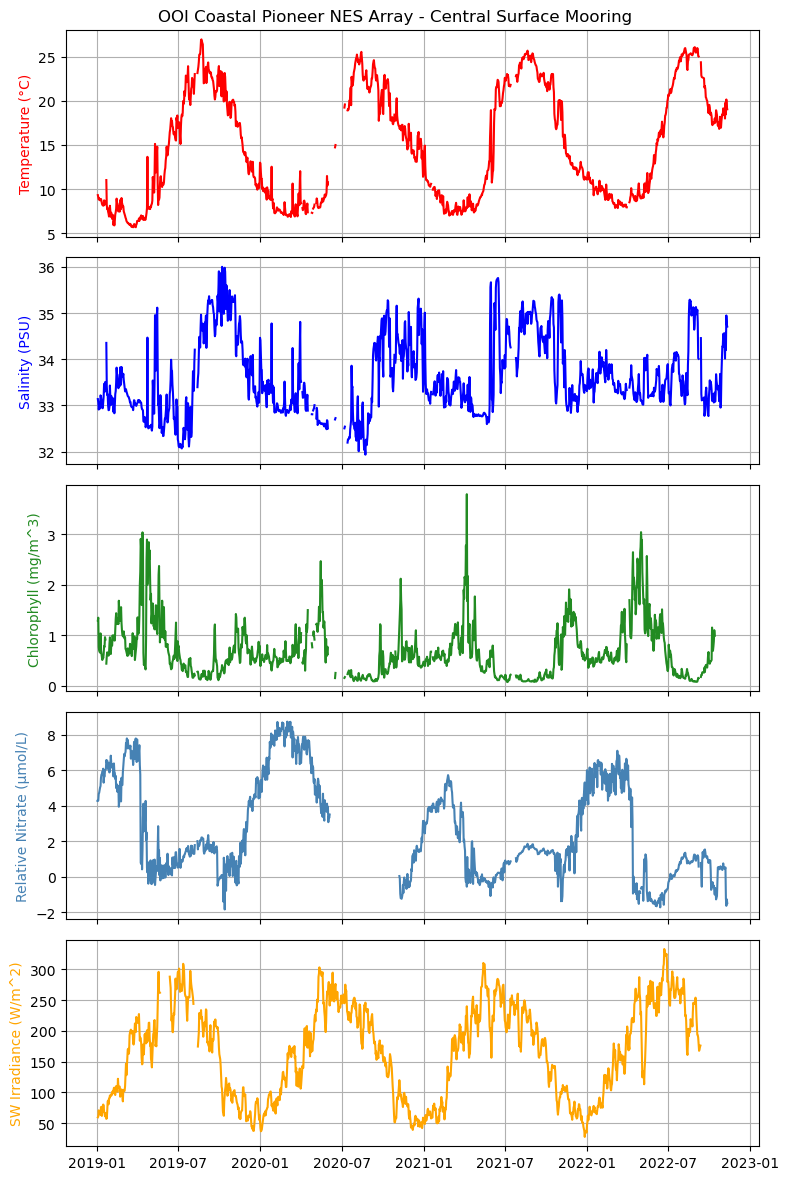

In [5]:
# Plot Temperature, Salinity, Chlorophyll, Nitrate, and Irradiance on subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 12), sharex=True)

# Plot Temperature
ax1.plot(df_merged.index, df_merged['sea_water_temperature'], color='red', label='Temperature')
ax1.set_ylabel('Temperature (°C)', color='red')
ax1.grid(True)

# Plot Salinity
ax2.plot(df_merged.index, df_merged['sea_water_practical_salinity'], color='blue', label='Salinity')
ax2.set_ylabel('Salinity (PSU)', color='blue')
ax2.grid(True)

# Plot Chlorophyll
ax3.plot(df_merged.index, df_merged['mass_concentration_of_chlorophyll_a_in_sea_water'], color='forestgreen', label='Chlorophyll')
ax3.set_ylabel('Chlorophyll (mg/m^3)', color='forestgreen')
ax3.grid(True)

# Plot Nitrate
ax4.plot(df_merged.index, df_merged['mole_concentration_of_nitrate_in_sea_water_suna'], color='steelblue', label='Nitrate')
ax4.set_ylabel('Relative Nitrate (µmol/L)', color='steelblue')
ax4.grid(True)

# Plot Irradiance
ax5.plot(df_merged.index, df_merged['netsirr'], color='orange', label='Irradiance')
ax5.set_ylabel('SW Irradiance (W/m^2)', color='orange')
ax5.grid(True)

plt.suptitle('OOI Coastal Pioneer NES Array - Central Surface Mooring')
plt.tight_layout()
fig.savefig('data/lab9_primary_production.png');


In [6]:
# Export the data to CSV
df_merged.index = df_merged.index.date
df_merged.index.name = 'Date'
df_merged.columns = ['Chlorophyll', 'Salinity', 'Temperature', 'Nitrate', 'Shortwave Irradiance']
df_merged.round(3).to_csv('data/lab9_primary_production.csv')